In [802]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import random
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

The initial phase of machine learning invariably involves collecting data and refining it to an optimal format suitable for input into the training model. We are already given our dataset, ence forth we only need to do the processing part.

## Creating the Dataframe

We now must create a dataframe in order to access and work with the data in the csv file. We will be using Pandas as it's a powerful and user-friendly library for data manipulation and analysis in Python. 

As we can see, all data points are loaded correctly.

In [803]:
df = pd.read_csv('data/Autism Dataset for Toddlers.csv')

display(df.head())
display(df.describe())

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score
count,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000,1054.000000
mean,527.500000,0.563567,0.448767,0.401328,0.512334,0.524668,0.576850,0.649905,0.459203,0.489564,0.586338,27.867173,5.212524
std,304.407895,0.496178,0.497604,0.490400,0.500085,0.499628,0.494293,0.477226,0.498569,0.500128,0.492723,7.980354,2.907304
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000
25%,264.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000,3.000000
50%,527.500000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,30.000000,5.000000
75%,790.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,8.000000
max,1054.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,10.000000


### Check missing data

There's no missing data, so we are free to move forward

In [804]:
df.isna().any()


Case_No                   False
A1                        False
A2                        False
A3                        False
A4                        False
A5                        False
A6                        False
A7                        False
A8                        False
A9                        False
A10                       False
Age_Mons                  False
Qchat-10-Score            False
Sex                       False
Ethnicity                 False
Jaundice                  False
Family_mem_with_ASD       False
Who completed the test    False
Class/ASD Traits          False
dtype: bool

## Encoding the target variable

Before moving forward, we must note the fact that the target variable (the result that the model will try to predict) is not in a suitable format for analysis. We can easily use LabelEncoder to transform it into an Integer value, where 1 represents a positive ASD Traits result and 0 represents a negative result.

In [805]:
df.rename(columns={'Class/ASD Traits ': 'Class/ASD Traits'}, inplace=True)

encoder = LabelEncoder()

df['Class/ASD Traits'] = encoder.fit_transform(df['Class/ASD Traits'])
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,0
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,1
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,1
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,1
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,1


# Data Analysis

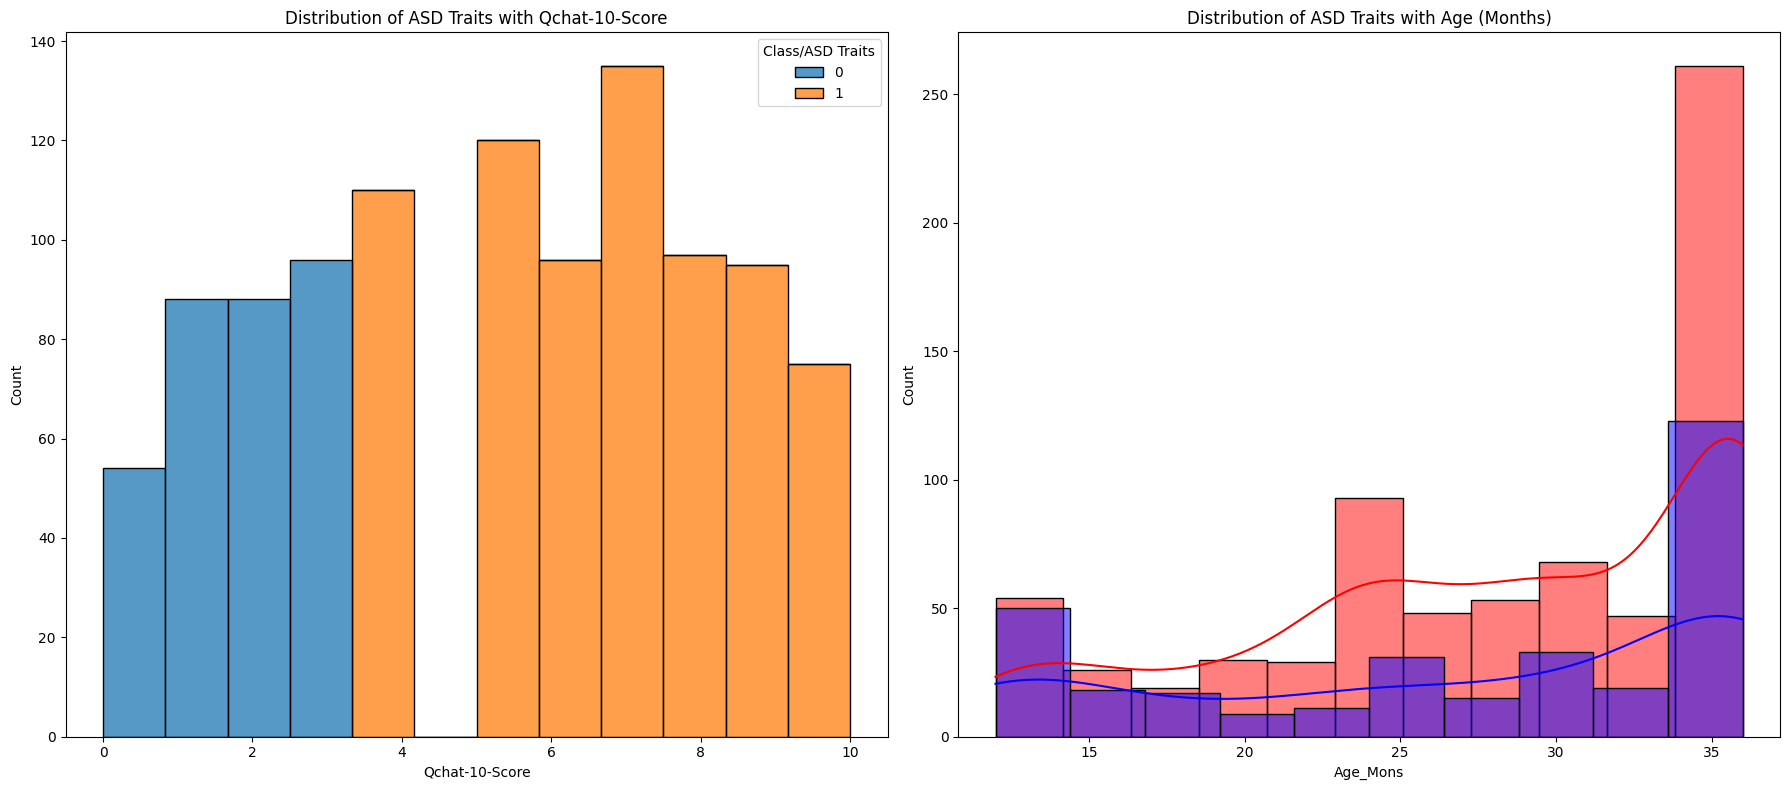

In [806]:
# Divide the DataFrame based on ASD diagnosis
df1 = df[df['Class/ASD Traits'] == 1]
df2 = df[df['Class/ASD Traits'] == 0]

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot distribution of ASD traits with Qchat-10-Score
sb.histplot(data=df, x='Qchat-10-Score', hue='Class/ASD Traits', multiple='stack', ax=axes[0])
axes[0].set_title('Distribution of ASD Traits with Qchat-10-Score')

# Plot distribution of ASD traits with Age in Months
sb.histplot(data=df1, x='Age_Mons', color='red', label='ASD Traits', kde=True, ax=axes[1])
sb.histplot(data=df2, x='Age_Mons', color='blue', label='Non ASD Traits', kde=True, ax=axes[1])
axes[1].set_title('Distribution of ASD Traits with Age (Months)')

plt.tight_layout()
plt.show()

The first graph shows the correlation between the *Qchat-10-Score* and the target variable. This shows us that those are 2 directly correlated and that having a value above 3 means that the toddler does in fact have ASD traits. Therefore, we must not use it to train the model and we will be removing it from the prepared dataframe.

The second graph shows the correlation between the *age of the child in months at the time of testing* and the target variable. A direct correlation doesn't immediately jump out, therefore we can assume this can be used to train the model, although we will still subject it to further analysis

In [807]:
#Remove Qchat-10-Score from dataframe
df.drop(['Qchat-10-Score'], axis=1, inplace=True)


### Encoding Non Numerical Features

In [808]:
# Encode categorical variables
df['Jaundice'] = encoder.fit_transform(df['Jaundice'])
df['Family_mem_with_ASD'] = encoder.fit_transform(df['Family_mem_with_ASD'])
df['Sex'] = encoder.fit_transform(df['Family_mem_with_ASD'])
df['Ethnicity'] = encoder.fit_transform(df['Family_mem_with_ASD'])
df['Who completed the test'] = encoder.fit_transform(df['Family_mem_with_ASD'])

We will be removing Case_no as it provides no useful information.

In [809]:
#RemoveCase_No the test from dataframe
df.drop(["Case_No"], axis=1, inplace=True)

### Correlation with Target Variable

To note that as most of our features are categorical with a few being categorical, we should employ a better method for calculating the correlation other than the inbuilt **corr()** function from the pandas library. Therefore, we're using the **cramers_V** method as a measure of association between categorical variables. Cramér's V is particularly suited for assessing the strength of association between categorical variables, including binary variables, providing a reliable indication of their relationship.

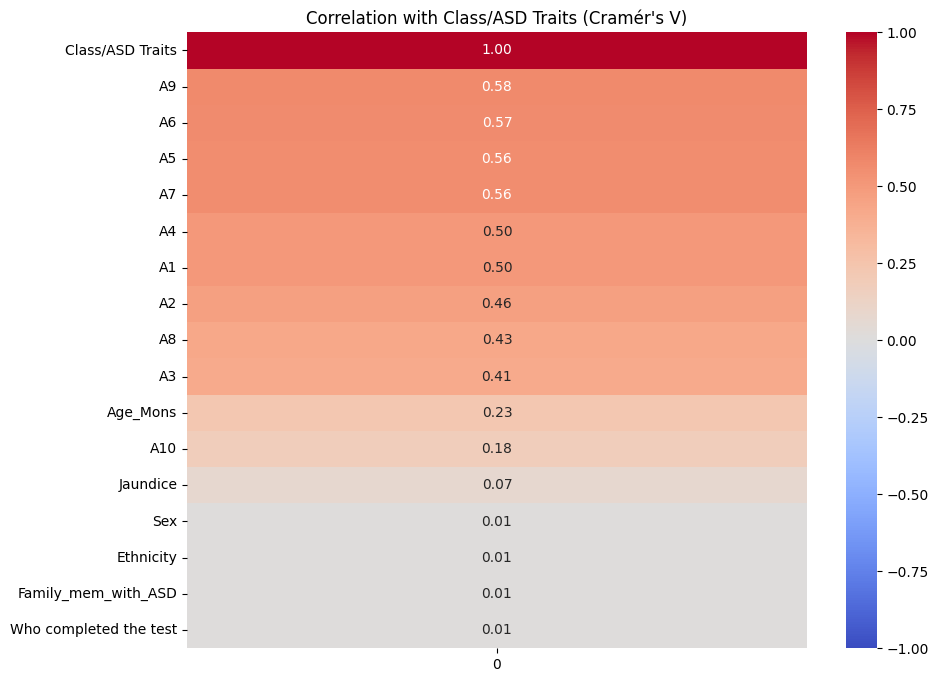

In [810]:
def cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab) 
    mini = min(crosstab.shape) - 1
    return np.sqrt(stat / (obs * mini))

# Calculate Cramér's V for each variable in the DataFrame with respect to 'Class/ASD Traits'
correlation_with_target = df.apply(lambda x: cramers_V(x, df['Class/ASD Traits']), axis=0)

# Sort correlation values in ascending order
correlation_with_target_sorted = correlation_with_target.sort_values(ascending=False)

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_with_target_sorted.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation with Class/ASD Traits (Cramér\'s V)')
plt.show()

### Correlation Matrix

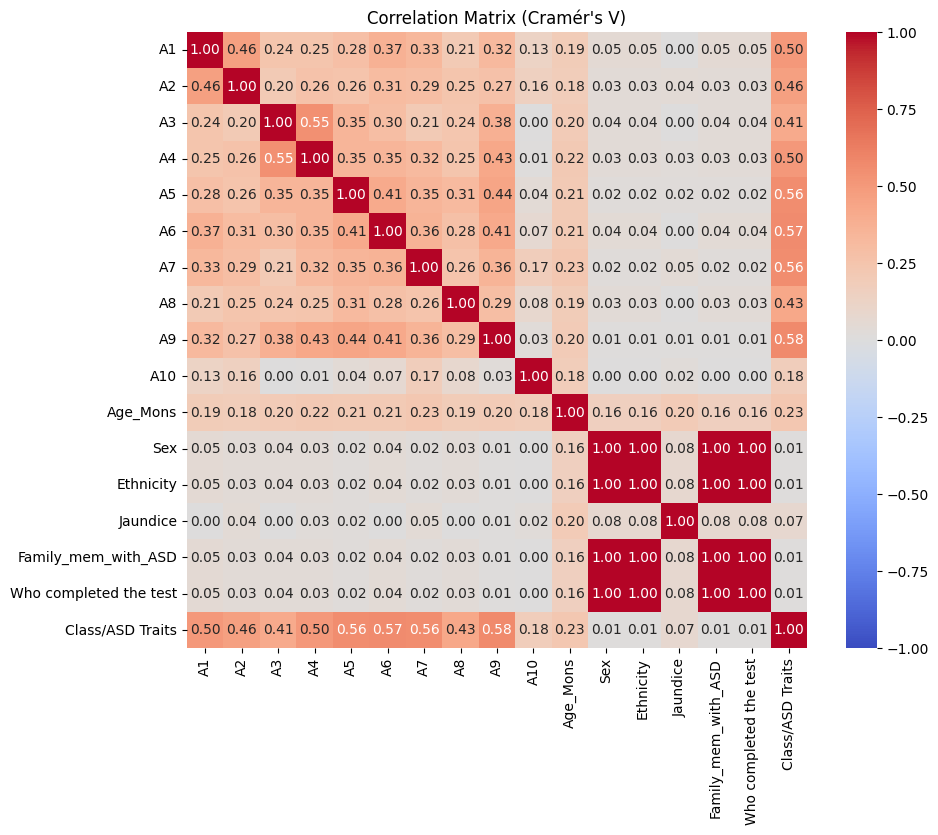

In [811]:
# Calculate Cramér's V for each pair of variables in the DataFrame
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
for col1 in df.columns:
    for col2 in df.columns:
        correlation_matrix.loc[col1, col2] = cramers_V(df[col1], df[col2])

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix (Cramér\'s V)')
plt.show()

### Highly Correlated Features

Two features are highly correlated when their correlation value surpasses a certain threshold, which we will be giving the value of 0.8 . When these pair exists, we remove one of the features from the dataframe as it can lead to multicollinearity issues and doesn't provide additional meaningful information for modeling. Removing one of the highly correlated features helps in reducing redundancy and improving the model's interpretability and performance.

In [812]:
# Define the correlation threshold
threshold = 0.8 

# Create an empty list to store highly correlated feature pairs
highly_correlated_pairs = []

# Iterate through the correlation matrix to find highly correlated feature pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            highly_correlated_pairs.append((feature1, feature2))

# Print highly correlated feature pairs
if len(highly_correlated_pairs) > 0:
    print("Highly correlated feature pairs:")
    for pair in highly_correlated_pairs:
        print(pair)
else:
    print("No highly correlated feature pairs found.")

Highly correlated feature pairs:
('Sex', 'Ethnicity')
('Sex', 'Family_mem_with_ASD')
('Sex', 'Who completed the test')
('Ethnicity', 'Family_mem_with_ASD')
('Ethnicity', 'Who completed the test')
('Family_mem_with_ASD', 'Who completed the test')


Given that we do, in fact, find highly correlated features, we must now remove one feature from each highly correlated pair to reduce multicollinearity and improve the performance of our models.

In [813]:
# Remove highly correlated features
for pair in highly_correlated_pairs:
    # Get the feature to remove from each pair
    feature_to_remove = pair[0]
    
    # Check if the feature exists in the DataFrame before trying to drop it
    if feature_to_remove in df.columns:
        df.drop(columns=feature_to_remove, inplace=True)
        print(f"Feature '{feature_to_remove}' has been removed.")


Feature 'Sex' has been removed.
Feature 'Ethnicity' has been removed.
Feature 'Family_mem_with_ASD' has been removed.


# Preparing the dataframe for model training

In [814]:
# Separate the target from the features
target = df['Class/ASD Traits']
features = df.drop(['Class/ASD Traits'],axis=1)

## Undersampling

In [815]:
#Count data for each of the results
unique_values, counts = np.unique(target, return_counts=True)

print(f"{counts[0]} negative results!")
print(f"{counts[1]} positive results!")


326 negative results!
728 positive results!


In our case, undersampling emerges as the preferred approach due to the substantial size of our dataset and the significant class imbalance. With nearly double the number of positive results compared to negative results, oversampling techniques might lead to an excessively inflated dataset, potentially introducing noise and overfitting issues. Undersampling with NearMiss allows us to selectively reduce the majority class instances while preserving the overall distribution, ensuring a more balanced representation of both classes in the training data. This approach enhances the model's ability to learn meaningful patterns from the data, leading to more robust and reliable predictions, particularly in scenarios where correctly identifying minority instances is critical.

NearMiss is an undersampling technique that works by selecting instances from the majority class that are closest to those in the minority class. By focusing on the instances that are most relevant to the minority class, NearMiss enhances the separation between the classes, leading to improved model performance and generalization.

In [816]:
# Determine the desired number of instances for both classes
desired_count = min(np.sum(target == 1), np.sum(target == 0))

# Create NearMiss instance to balance the classes
nm = NearMiss(sampling_strategy={0: desired_count, 1: desired_count})

# Undersample the dataset using NearMiss
features_resampled, target_resampled = nm.fit_resample(features, target)

# Print the count of positive and negative results after undersampling
unique_values, counts = np.unique(target_resampled, return_counts=True)
print(f"Number of negative results after undersampling: {counts[0]}")
print(f"Number of positive results after undersampling: {counts[1]}")

Number of negative results after undersampling: 326
Number of positive results after undersampling: 326


### Data Splitting

In [817]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=420)

# Model Training

We are now in the fun part. We're utilizing scikit-learn, a comprehensive machine learning library in Python, for this task. Our choice of algorithms encompasses a diverse range of approaches. We are going to go model by model, test it and analyze the results.

We are going to use the following **train_test_classifier()** function to test each of the models with 200 random values and print graphs that show the efficiency of said model.

In [818]:
# Function to train and test each classifier
def train_test_classifier(name, classifier, X_train, y_train, X_test, y_test):
    # Model training
    classifier.fit(X_train, y_train)
    
    # Model testing
    y_pred = classifier.predict(X_test)
    
    # Print classification report
    print(classification_report(y_test, y_pred))
    
    # Test 200 random samples
    random_indices = random.sample(range(len(X_test)), 200)
    random_X_test = X_test.iloc[random_indices]
    random_y_test = y_test.iloc[random_indices]
    random_y_pred = classifier.predict(random_X_test)
    
    # Calculate accuracy for random samples
    accuracy = accuracy_score(random_y_test, random_y_pred)
    print(f"Accuracy on random samples: {accuracy:.2f}\n")
    
    # Create subplots for classification report and confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot classification report
    report = classification_report(y_test, y_pred)
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split()
        row['class'] = 'Yes' if row_data[0] == '1' else 'No'
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1-score'] = float(row_data[3])
        report_data.append(row)
    df = pd.DataFrame(report_data)
    df.set_index('class', inplace=True)
    ax = df.plot(kind='bar', ax=axes[0])
    ax.set_title(f'{name} Classifier - Classification Report')
    ax.set_xlabel('Class/ASD Traits')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc='lower left')
    
    # Add value annotations on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

    # Plot confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    labels = ['Negative', 'Positive']
    sb.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f'{name} Classifier - Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

## Decision Tree Classifier

The Decision Tree Classifier is a popular algorithm used in classification tasks. It works by recursively partitioning the feature space into regions that are homogeneous with respect to the target variable. At each node of the tree,  the algorithm selects the feature that best splits the data, based on some criterion such as Gini impurity or information gain, in order to maximize the purity of the resulting subsets. This process continues until the  data is perfectly classified or a stopping criterion is met.

              precision    recall  f1-score   support

           0       0.87      0.90      0.89        73
           1       0.95      0.93      0.94       138

    accuracy                           0.92       211
   macro avg       0.91      0.92      0.91       211
weighted avg       0.92      0.92      0.92       211

Accuracy on random samples: 0.92



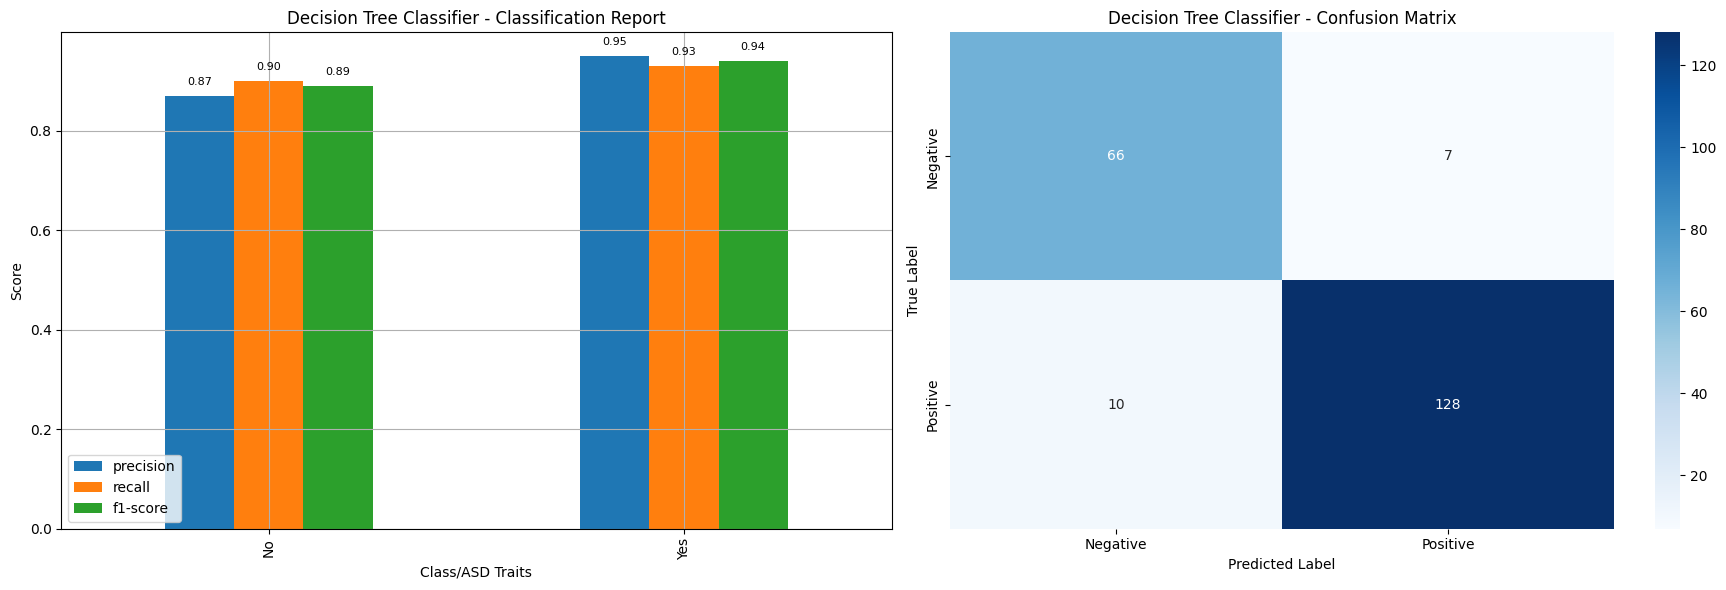

In [819]:
dt_classifier = DecisionTreeClassifier()

train_test_classifier("Decision Tree", dt_classifier, X_train, y_train, X_test, y_test)

## k-Nearest Neighbors Classifier

K-Nearest Neighbors (KNN)  supervised learning method that relies on the concept of similarity, where a new instance's class label is determined by the majority class among its k nearest neighbors in the feature space. Essentially, KNN assigns the class label that is most prevalent among its nearby data points. The choice of k, representing the number of neighbors to consider, is pivotal in KNN, influencing the model's balance between bias and variance. A smaller k value results in more intricate decision boundaries, which may lead to overfitting, while a larger k value can cause underfitting by oversimplifying the model.

We will be testing a range of k values to choose the adequate value for our model.

Best k value: 5
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        73
           1       0.98      0.93      0.96       138

    accuracy                           0.94       211
   macro avg       0.93      0.95      0.94       211
weighted avg       0.95      0.94      0.94       211

Accuracy on random samples: 0.94



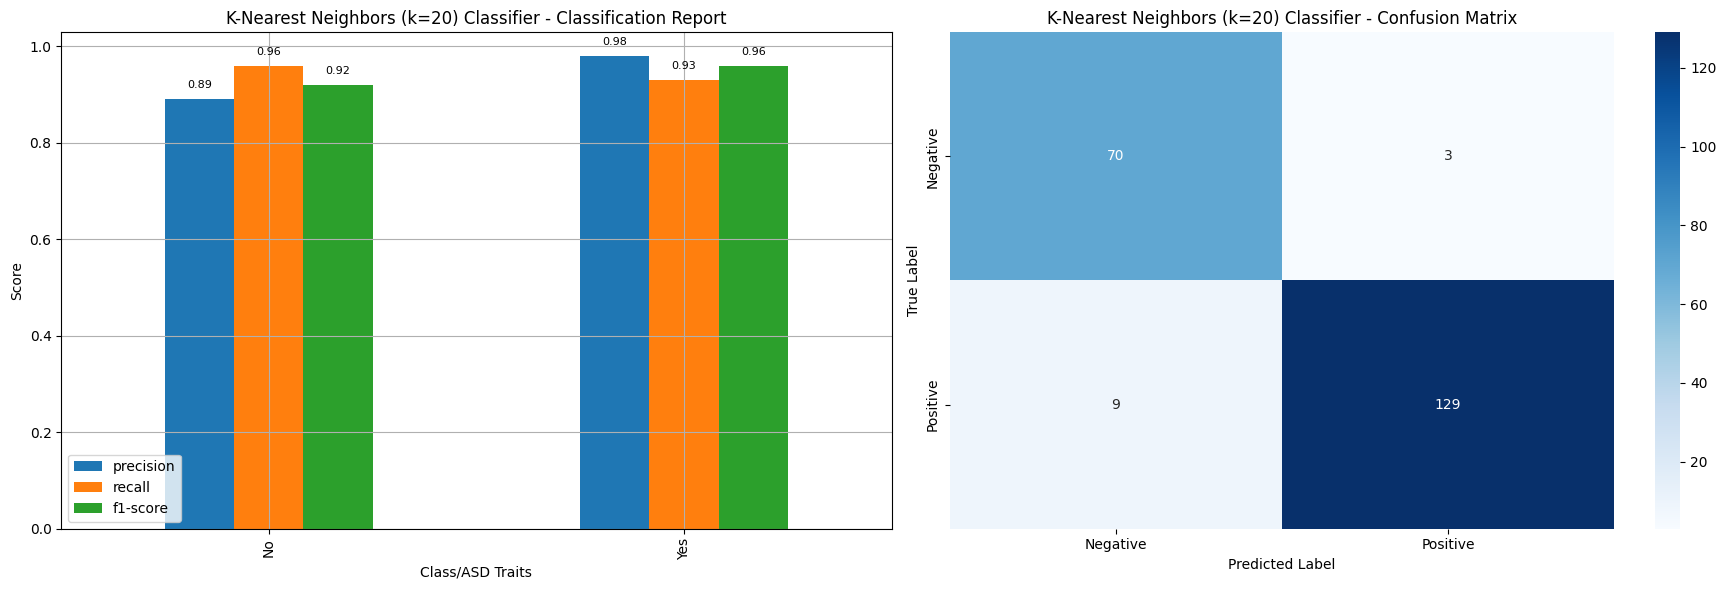

In [820]:
k_values = range(1, 21)

best_accuracy = 0
best_k = 0

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print("Best k value:", best_k)

#We will be using the best k value to plot the graphs
train_test_classifier("K-Nearest Neighbors (k={})".format(k), knn_classifier, X_train, y_train, X_test, y_test)


## Support Vector Machine Classifier


The Support Vector Machine (SVM) classifier is a supervised learning algorithm that works by finding the optimal hyperplane that best separates different classes in the feature space. SVM aims to maximize the margin, which is the distance between the hyperplane and the nearest data points from each class. By maximizing the margin, SVM not only identifies the decision boundary but also enhances the model's generalization capability, making it less prone to overfitting. We are using a non-linear classification.

              precision    recall  f1-score   support

           0       1.00      0.49      0.66        73
           1       0.79      1.00      0.88       138

    accuracy                           0.82       211
   macro avg       0.89      0.75      0.77       211
weighted avg       0.86      0.82      0.81       211

Accuracy on random samples: 0.82



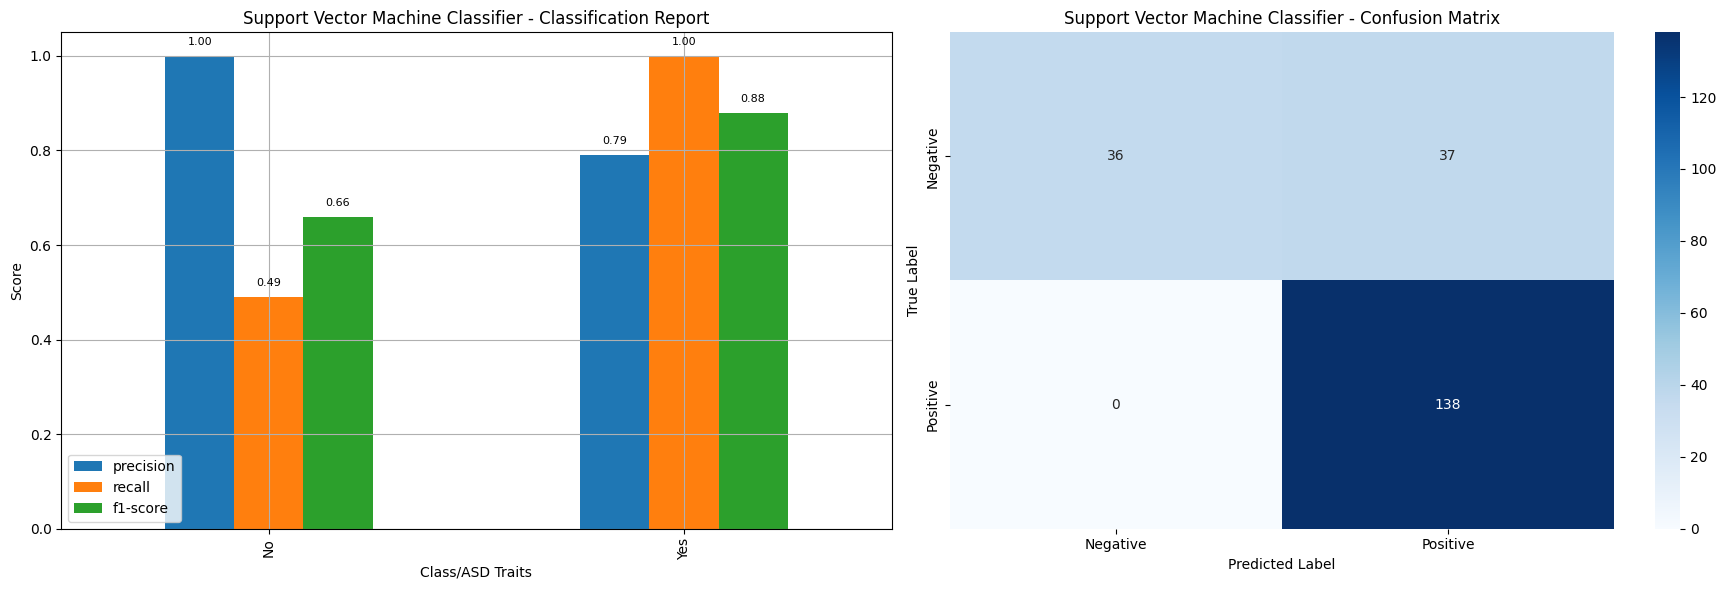

In [821]:
svm_classifier = SVC()

train_test_classifier("Support Vector Machine", svm_classifier, X_train, y_train, X_test, y_test)

## Random Forest Classifier

Random Forest Classifier is a learning method that constructs multiple decision trees during training and outputs the class that is the mode of the classes of the individual trees. It's robust, handles both binary and categorical features well, and is less prone to overfitting, making it suitable for small datasets.

              precision    recall  f1-score   support

           0       0.99      0.93      0.96        73
           1       0.96      0.99      0.98       138

    accuracy                           0.97       211
   macro avg       0.98      0.96      0.97       211
weighted avg       0.97      0.97      0.97       211

Accuracy on random samples: 0.97



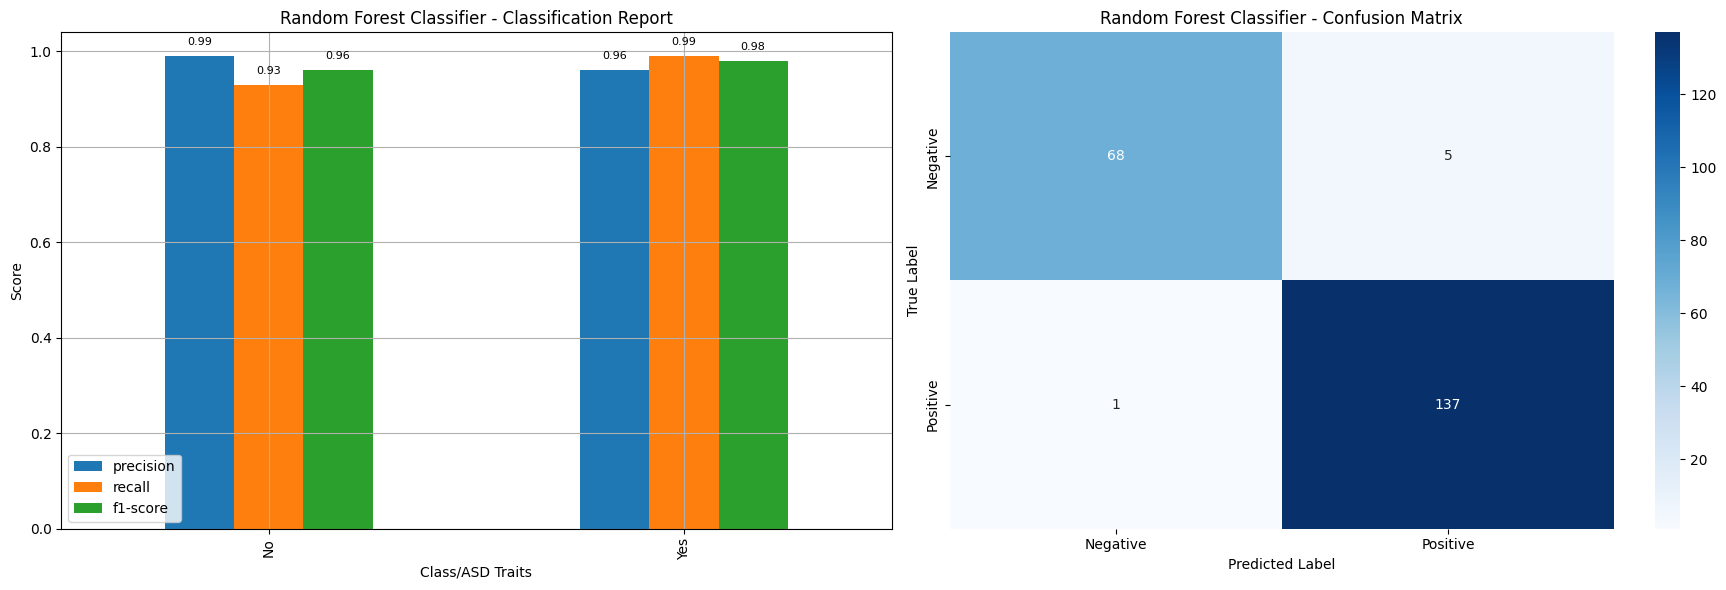

In [822]:
random_forest_classifier = RandomForestClassifier()

train_test_classifier("Random Forest", random_forest_classifier, X_train, y_train, X_test, y_test)

## Multi-layer Perceptron (MLP) Classifier

The Multi-layer Perceptron Classifier, a type of artificial neural network, is a versatile and powerful tool for classification tasks. MLPs consist of multiple layers of interconnected neurons, each layer processing the input data through a series of weighted connections and non-linear activation functions. This architecture enables MLPs to learn complex patterns and relationships within the data.

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        73
           1       0.99      1.00      0.99       138

    accuracy                           0.99       211
   macro avg       0.99      0.99      0.99       211
weighted avg       0.99      0.99      0.99       211

Accuracy on random samples: 0.99



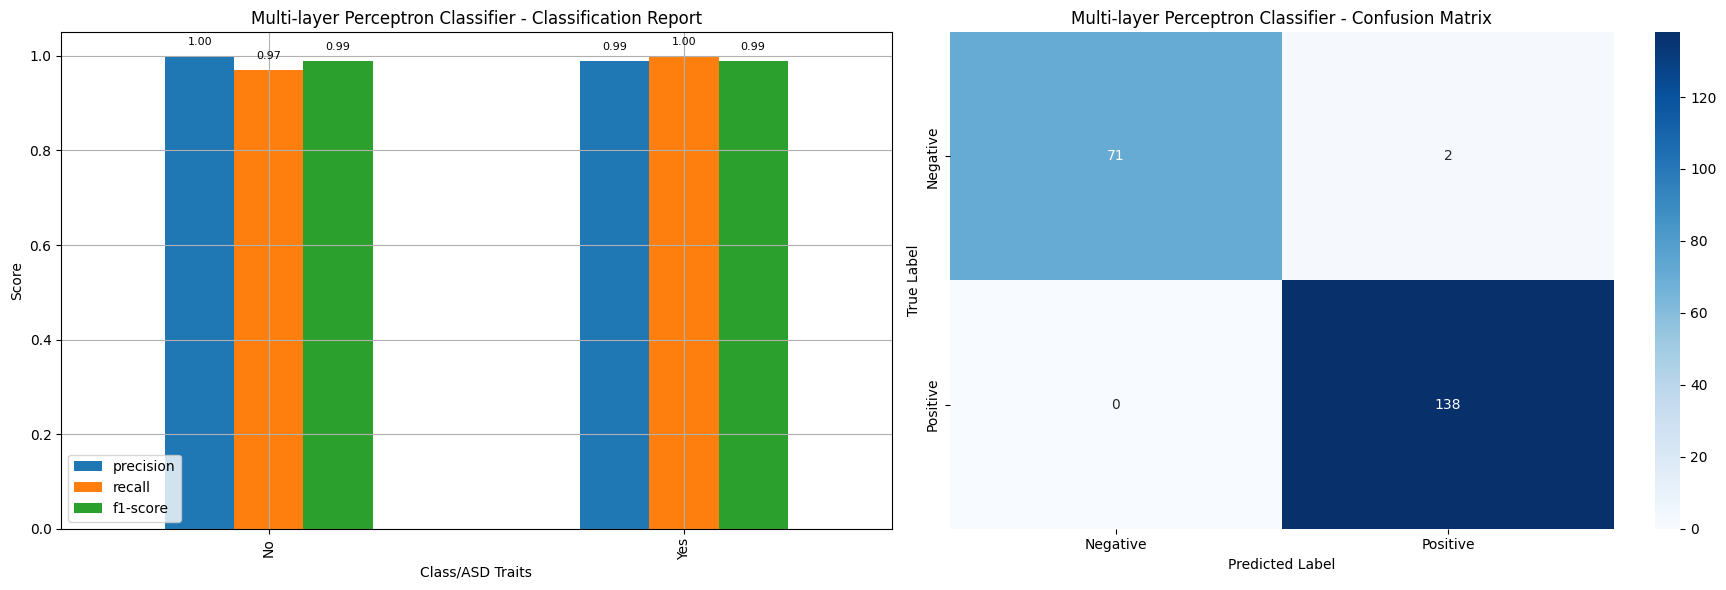

In [823]:
mlp_classifier = MLPClassifier()

train_test_classifier("Multi-layer Perceptron", mlp_classifier, X_train, y_train, X_test, y_test)

## Conclusions

Now it's time to compare the models, analyze the results, and choose the best of them:

- **Good Performers: Decision Tree and K-Nearest Neighbors (KNN):**
  - Both the Decision Tree Classifier and the K-Nearest Neighbors (KNN) Classifier demonstrated solid performance in this analysis. The Decision Tree Classifier offers interpretability and ease of use, making it a suitable choice for datasets with binary features. Additionally, KNN achieved an optimal balance between bias and variance, resulting in accurate predictions. These models are effective in scenarios where the decision boundary is relatively simple and well-defined.

- **Poor Performer: Support Vector Machine (SVM):**
  - The Support Vector Machine (SVM) Classifier performed relatively poorly compared to other models. This could be attributed to its sensitivity to dataset characteristics, particularly when the data is not linearly separable. SVMs struggle to handle complex datasets with nonlinear decision boundaries, resulting in suboptimal performance. Additionally, SVMs may require careful tuning of hyperparameters and kernel functions to achieve better results.

- **Top Performers: Random Forest and MLPClassifier:**
  - The Random Forest Classifier and the MLPClassifier (Neural Network) emerged as the top performers in this analysis. The Random Forest Classifier demonstrated robustness and generalization capability, effectively capturing intricate patterns in the data. Its ensemble learning approach reduces overfitting and improves performance, making it suitable for complex datasets. Similarly, the MLPClassifier showcased high accuracy and the ability to capture complex relationships in the data. Neural networks excel at learning nonlinear relationships, making them well-suited for datasets with binary features.

Based on the analysis, the Random Forest Classifier and the MLPClassifier are the preferred models for this dataset. Both models offer high accuracy and robust performance, making them suitable for classification tasks with binary features. Additionally, their ability to capture complex relationships in the data makes them well-equipped to handle the nuances of the dataset. Therefore, either the Random Forest Classifier or the MLPClassifier can be chosen as the final model, depending on specific requirements such as interpretability, computational resources, and model complexity.
